# Run Below codes for loading files and running DV/V

In [1]:
using SeisNoise, SeisIO, Plots
using Dates 

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/home/seismic/.julia/packages/Plots/1KWPG/src/backends/hdf5.jl", 36, UndefVarError(:Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f78ca7de47f, Ptr{Nothing} @0x00007f78ca87d70c, Ptr{Nothing} @0x00007f78ca87de75, Ptr{Nothing} @0x00007f78ca87d90d, Ptr{Nothing} @0x00007f78ca87e6d1, Ptr{Nothing} @0x00007f78ca87f2f7, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x00007f78ca89c7a3, Ptr{Nothing} @0x00007f78ca89ce3c, Ptr{Nothing} @0x00007f78ca89c9e4, Ptr{Nothing} @0x00007f78ca89c9e4, Ptr{Nothing} @0x00007f78ca89e629, Ptr{Nothing} @0x00007f78aa3d083a, Ptr{Nothing} @0x00007f78ca85ee09, Ptr{Nothing} @0x00007f78aa4c035a, Ptr{Nothing} @0x00007f78a9fddc15, Ptr{Nothing} @0x00007f78ca85ee09, Ptr{Nothing} @0x00007f78ca86f5d6, Ptr{Nothing} @0x00007f78a7f1689a, Ptr{Nothing} @0x00007f78ca85ee09, Ptr{Nothing} @0x00007f78ca87de95, Ptr{Nothing} @0x00007f78

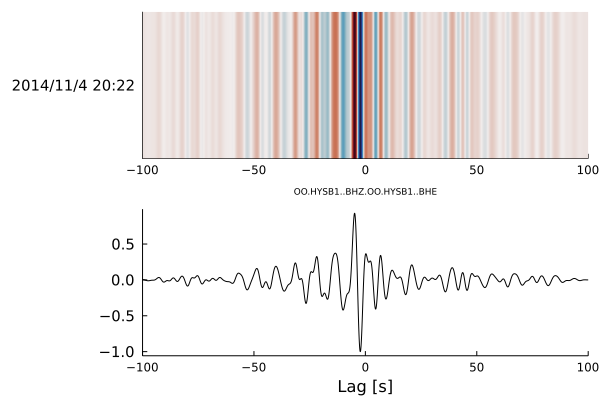

In [126]:
mnf = 0.1
mxf = 0.3
ndaystack = 30
inter = Day(ndaystack)

#d=load_corr("/data/wsd02/maleen_data/C_test/NV.NCBC..HHZ.NV.NCBC..HHE.jld2","ZE")
#d=load_corr("/data/wsd02/maleen_data/C_test/NV.NCBC..HHZ.NV.NCBC..HHE.jld2","ZE")
#d=load_corr("/data/wsd02/maleen_data/Correl_seismic/b/NV.NCBC..HHZ.NV.NCBC..HHE.jld2","ZE")
#d=load_corr("/data/wsd02/maleen_data/C_test/OO.HYS14..BHZ.OO.HYSB1..BHZ.jld2","ZZ")
d=load_corr("/data/wsd02/maleen_data/C_test/OO.HYSB1..BHZ.OO.HYSB1..BHE.jld2","ZE")
#d=load_corr("/data/wsd02/maleen_data/C_test/a/NV.NCBC..HHZ.NV.NCBC..HHE.jld2","ZE")
allstk=stack(d,allstack=true)
clean_up!(allstk,mnf,mxf)
abs_max!(allstk)
plot(allstk)

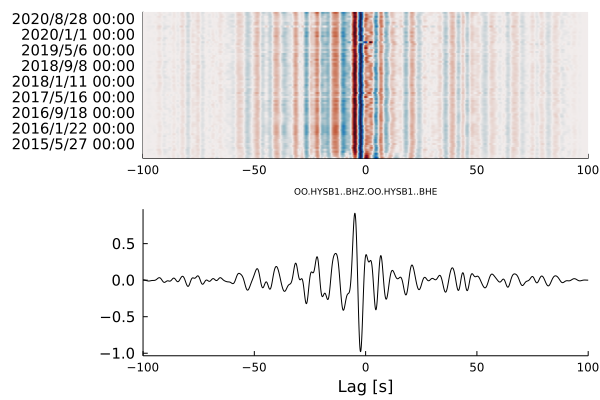

In [127]:
dailystk=stack(d,interval=inter)
clean_up!(dailystk,mnf,mxf)
abs_max!(dailystk)
plot(dailystk)

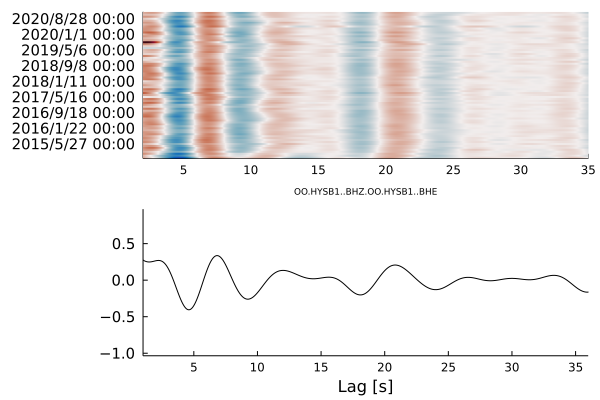

In [128]:
plot(dailystk,xlim=[2,35])

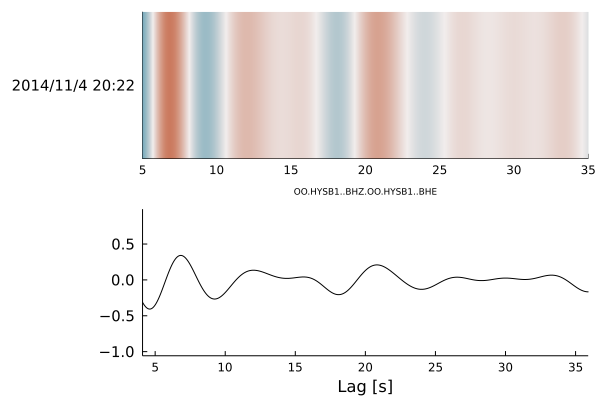

In [129]:
plot(allstk,xlim=[5,35])

### Resolving DV/V from Allstack and Daily Stack

In [130]:
using SeisDvv
fs=40.0     # sample frequency
win_len=5.0  # sliding window length
win_step=2.5 # sliding window step
j=size(dailystk.corr,2)
dvt=zeros(j)
cct=zeros(j)
cctb=zeros(j)
tmin = -90.
tmax = -10.

for i in 1:j#1890
    S1=Array(allstk.corr[:])
    S2=Array(dailystk.corr[:,i])
    rel_tmin_index = Int(floor((tmin + 100) * fs))
    rel_tmax_index = Int(floor((tmax + 100) * fs))

    window = collect(rel_tmin_index:rel_tmax_index)
    fmin = mnf
    fmax = mxf

    function evenly_spaced(a, b, n)
        h = (b-a)/(n-1)
        collect(a:h:b)
    end

    time=evenly_spaced(-100,100,size(dailystk.corr,1))

    dvv_ts, cc_ts, cdp_Ts, eps_ts, err_ts, allC_ts = SeisDvv.stretching(S1, S2, time, window, fmin, fmax, dvmin=-0.05, dvmax=0.05, ntrial=50);
    #dvmin=-0.01, dvmax=0.01
    dvt[i]=dvv_ts
    cct[i]=cc_ts
    cctb[i]=cdp_Ts
    
end

### Saving time, DVV, CC as as .CSV

In [131]:
using CSV
using Statistics

dt = map(unix2datetime, dailystk.t);
# Assuming datetime_vector is your 71-element Vector{DateTime} 
# and float_vector is your 71-element Vector{Float64}
datetime_vector = dt;  # fill this with your data
float_vector = dvt;  # fill this with your data
cctfilter = cct;

# Combine the vectors into a named tuple which CSV.File will interpret as a table
data = (DateTime=datetime_vector, Float=float_vector,cct);

# Write the data to a CSV file
#CSV.write("$(d.name)_t$(tmin)-$(tmax)_freq$(mnf)-$(mxf)_stk$(ndaystack).csv", data)

### filtering based on cc

In [132]:
# Set the threshold value
threshold = 0.80

# Filter the datetime and float vectors based on the threshold
filtered_indices = cct .>= threshold;
datetime_vector = datetime_vector[filtered_indices];
float_vector = float_vector[filtered_indices];
cctfilter = cct[filtered_indices];
#dtf = datetime_vector[filtered_indices]
#vtf = float_vector[filtered_indices]

### Filtering Outliers based on Quartile

In [133]:
# Calculate the Interquartile Range (IQR)
Q1 = quantile(float_vector, 0.20)
Q3 = quantile(float_vector, 0.80)
IQR = Q3 - Q1

# Calculate the lower and upper bounds to filter the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the vectors to remove the outliers
dtf = DateTime[]
dvtf = Float64[]
cctf = Float64[]
for i in 1:length(float_vector)
    if float_vector[i] >= lower_bound && float_vector[i] <= upper_bound
        push!(dtf, datetime_vector[i])
        push!(dvtf, float_vector[i])
        push!(cctf, cctfilter[i])
    end
end

In [134]:
# Calculate the mean and standard deviation
mean_value = mean(cct)
std_deviation = std(dvtf)

# Print the results
println("Mean of the float vector: $mean_value")
println("Standard deviation of the float vector: $std_deviation")

Mean of the float vector: 0.983072423630683
Standard deviation of the float vector: 0.13507358096519964


### Switch for Using unfiltered data

In [135]:
#dvtf = dvt
#dtf = dt

In [136]:
using Dates
using Plots

# Sample datetime_vector and dvtf
datetime_vector = dtf

# Find the minimum and maximum dates in the datetime_vector
min_date = minimum(datetime_vector)
max_date = maximum(datetime_vector)

# Generate all dates in the date rangeI'
all_dates = collect(min_date:Day(ndaystack):max_date)

# Find the dates that are in all_dates but not in datetime_vector (considering only the date part)
missing_dates = setdiff(all_dates, datetime_vector)

DateTime[]

In [137]:
using Plots
using Dates

# Assuming dt, dvt, cct, and dailystk are defined
#dt = map(unix2datetime, dailystk.t)
ticks = dtf[1:10:end]
tick = Dates.format.(ticks, "yyyy-mm-dd")

# First subplot
p1 = plot(scatter(dtf, dvtf), seriestype = :line, xticks = (ticks, tick), xrot = -30, ylabel="dv/v %", legend=false)
plot!(dtf, dvtf, seriestype = :line, xticks = (ticks, tick), xrot = -30, legend=false)
# For each missing date, add a vertical line to the plot
#for date in missing_dates
#    vline!(p1, [DateTime(date)], linecolor=:red, linewidth=2, linealpha=0.5, label="Missing Date")
#end


# Second subplot
p2 = plot(dtf, cctf, seriestype = :line, ylim = [0, 1], label = "cc", xticks = (ticks, tick), xrot = -30, left_margin = 10Plots.mm, ylabel="cc", xlabel="Date", legend=false)
hline!([0.8], label="Threshold", width=2, color=:red) # Adding a horizontal line at y=0.8

# Third subplot
p3 = plot(dailystk, left_margin = 10Plots.mm)

# The layout now specifies a grid of 3 rows and 1 column and gives the third plot even more vertical space compared to the first two.
l = @layout([a{0.3h}; b{0.2h}; c{0.5h}])

# Combine the plots
final_plot = plot(p1, p2, p3, layout = l, size = (1100, 1000), left_margin = 20Plots.mm, right_margin = 5Plots.mm)

# Save the plot
savefig(final_plot, "$(d.name)_t$(tmin)-$(tmax)_freq$(mnf)-$(mxf)_stk$(ndaystack)new.png")

#### Individual plots

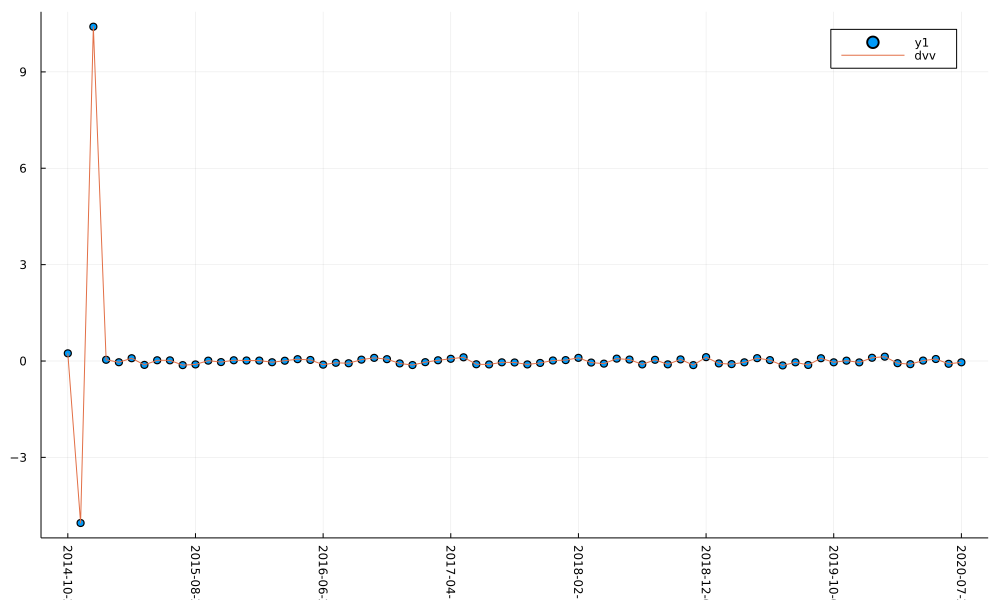

In [1161]:
using Plots
using Dates

# Assuming that dt and dvt are defined
dt = map(unix2datetime, dailystk.t)
ticks = dt[1:10:end]
tick = Dates.format.(ticks,"yyyy-mm-dd")
# Include xticks and xlims in the plot function

p = plot(scatter(dt, dvt), seriestype = :line, label = "dvv", xticks =(ticks,tick), xrot = -90, size=(1000, 600))
plot!(dt, dvt, seriestype = :line, label = "dvv", xticks =(ticks,tick), xrot = -90, size=(1000, 600))


In [ ]:
plot(dt,cct,seriestype = :line, ylim =[0,1], label = "cc", xticks =(ticks,tick), xrot = -30, size=(1000, 600))
#plot!(dt,cctb,seriestype = :line, ylim =[0,1], label = "cc?")

In [ ]:
using Plots
using Dates
using GLM
using DataFrames

# Sample data (ensure you've defined `dailystk.t` and `dvt` before this)
dt = map(unix2datetime, dailystk.t)

# Convert dates to a number for regression (you can use Dates.value to convert dates to Int64)
dt_values = Dates.value.(dt)

# Fit a linear regression model
df = DataFrame(Dates=dt_values, dvt=dvt)
lm1 = lm(@formula(dvt ~ Dates), df)

# Get predicted values from the model
predictions = predict(lm1)

ticks = dt[1:10:end]
tick = Dates.format.(ticks,"yyyy-mm-dd")

p = scatter(dt, dvt, label="dvv", alpha=0.5)
plot!(dt, predictions, seriestype = :line, color=:red, label = "Regression", xticks =(ticks,tick), xrot = -90, size=(1000, 500))
plot!(dt, dvt, seriestype = :line, label = "dvv", xticks =(ticks,tick), xrot = -60, size=(1000, 500))

#### Loads correlation for one day --> EN: between East and North , ZZ: between Z and Z channel

In [ ]:
using SeisNoise, SeisIO, Plots
using Dates
#d=load_corr("/data/wsd02/maleen_data/C_test/NV.NCBC..HHZ.NV.NCBC..HHE.jld2","ZE",day="2020-01-17")
#d=load_corr("/data/wsd02/maleen_data/C_test/a/NV.NCBC..HHE.NV.NCBC..HHN.jld2","EN")
d=load_corr("/data/wsd02/maleen_data/C_test/OO.HYS14..BHZ.OO.HYSB1..BHE.jld2","ZE")

In [ ]:
clean_up!(d,mnf,mxf)
abs_max!(allstk)
plot(allstk)

In [ ]:
allstk=stack(d,allstack=true)
allstk